# Clustering

According to the paper [Benchmarking clustering algorithms on estimating the number of cell types from single-cell RNA-sequencing data](https://doi.org/10.1186/s13059-022-02622-0) and their figure (below), Monocle3 provides one of the best performing clustering algorithms to automatically choose the optimal number of clusters. Hence, we will use Monocle3 for clustering.

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13059-022-02622-0/MediaObjects/13059_2022_2622_Fig8_HTML.png)

In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_leiden_monocle3_subset.csv"

In [ ]:
suppressPackageStartupMessages({
    library(monocle3)
    library(Seurat)
    })
srt = schard::h5ad2seurat(input_file,load.X=F) # do not load layers
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)

In [ ]:
suppressPackageStartupMessages(library(monocle3))
library(SeuratWrappers)
cds = as.cell_data_set(srt)
rm(srt)
reducedDimNames(cds) = c("Diffmap", "PCA", "tSNE", "UMAP")
stopifnot(!(all(cds@assays@data$logcounts[1:50]%%1 == 0))) # check values (not integer)cds

class: cell_data_set 
dim: 11449 22799 
metadata(0):
assays(2): counts logcounts
rownames(11449): NOC2L KLHL17 ... MT-ND6 MT-CYB
rowData names(0):
colnames(22799): GTAAGAACAGCTTTCGAACGGGAA-1 TGAATGTCACAGCAACATCCCAAC-1
  ... TAACGCCTCTCCATCTATACGTCA-1 CTAACCGGTACGATTCAGTAGGCT-1
colData names(48): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(4): Diffmap PCA tSNE UMAP
mainExpName: RNA
altExpNames(0):

In [ ]:
# Preprocess and analyze with Monocle3
# cds <- preprocess_cds(cds)
# plot_pc_variance_explained(cds)
# cds <- reduce_dimension(cds, umap.fast_sgd=TRUE, cores = 8)

set_nn_control: call stack: IRkernel::main() => kernel$run() => handle_shell() => executor$execute() => tryCatch() => tryCatchList() => tryCatchOne() => doTryCatch() => tryCatchList() => tryCatchOne() => doTryCatch() => evaluate() => withRestarts() => withRestartList() => withOneRestart() => doWithOneRestart() => withRestartList() => withOneRestart() => doWithOneRestart() => with_handlers() => eval() => eval() => withCallingHandlers() => withVisible() => eval() => eval() => cluster_cells() => set_nn_control()

  nn_control: 

    method: annoy

    metric: euclidean

    n_trees: 50

    search_k: 2000

    cores: 1

    grain_size: 1

Running louvain clustering algorithm ...

Run kNN based graph clustering starts:
  -Input data of 22799 rows and 2 columns
  -k is set to 20

  Finding nearest neighbors...

set_nn_control: call stack: IRkernel::main() => kernel$run() => handle_shell() => executor$execute() => tryCatch() => tryCatchList() => tryCatchOne() => doTryCatch() => tryCatchList(

Running louvain iteration  1 ...
Running louvain iteration  2 ...


Maximal modularity is 0.927313338764686; corresponding resolution is No resolution


Run kNN based graph clustering DONE, totally takes 1.95677804946899 s.



  -Number of clusters: 41 


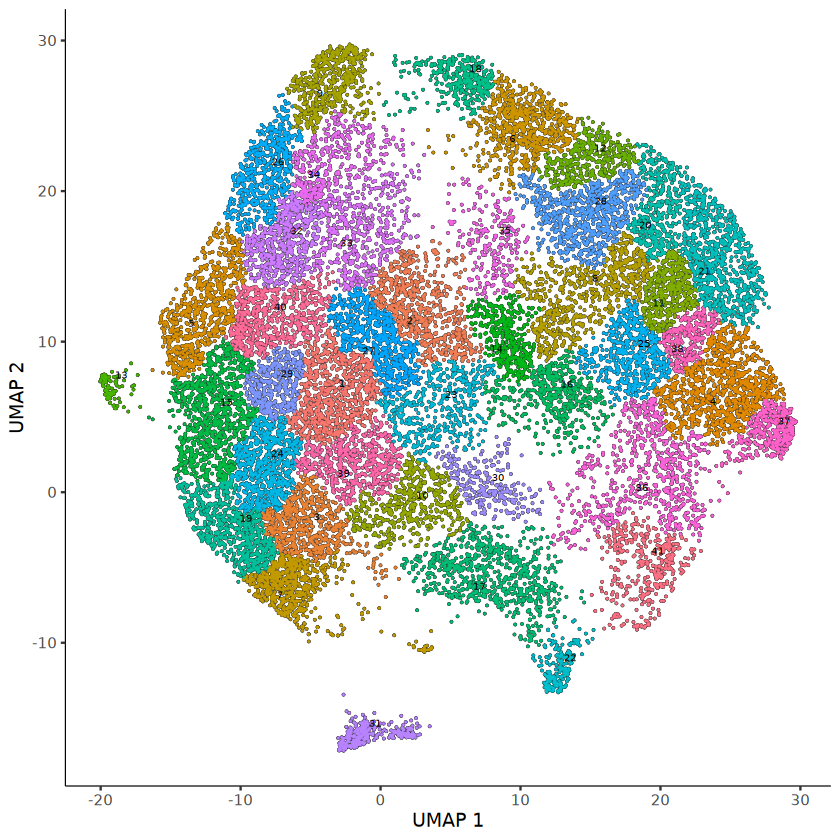

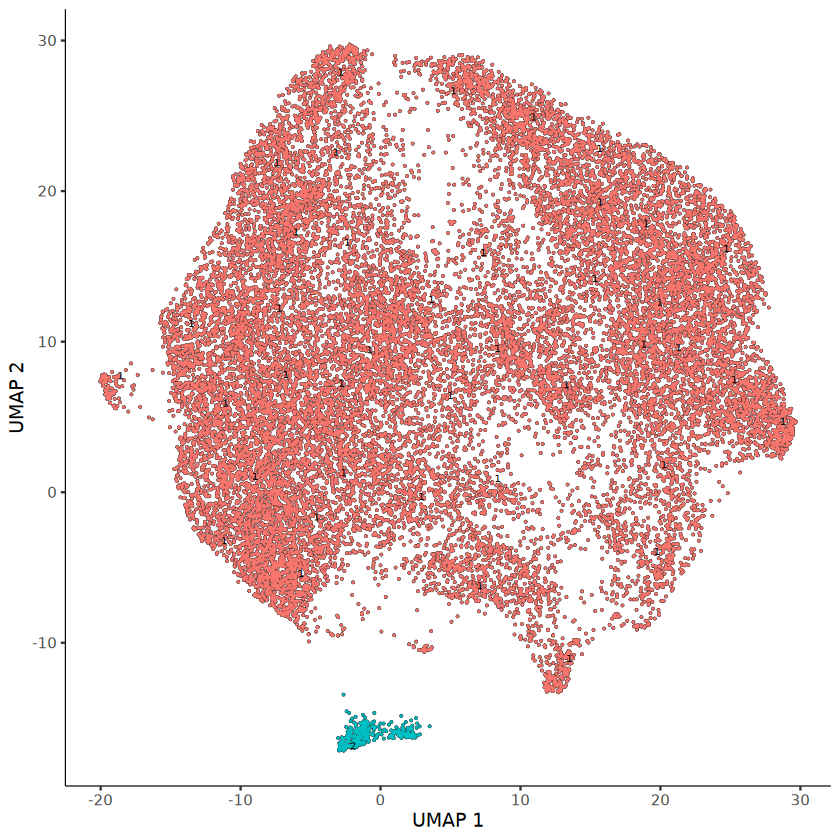

In [ ]:
cds <- cluster_cells(cds, verbose = T, cluster_method = "louvain", cores = 8)
plot_cells(cds, color_cells_by="cluster", reduction_method = "UMAP", show_trajectory_graph = F)
plot_cells(cds, color_cells_by="partition", reduction_method = "UMAP", show_trajectory_graph = F)
write.csv(clusters(cds), sub("leiden", "louvain", output_csv))

In [ ]:
cds <- cluster_cells(cds, verbose = T, cluster_method = "leiden")
plot_cells(cds, color_cells_by="cluster", reduction_method = "UMAP", show_trajectory_graph = F)
plot_cells(cds, color_cells_by="partition", reduction_method = "UMAP", show_trajectory_graph = F)
write.csv(clusters(cds), output_csv)


Attaching package: ‘magrittr’


The following object is masked from ‘package:GenomicRanges’:

    subtract




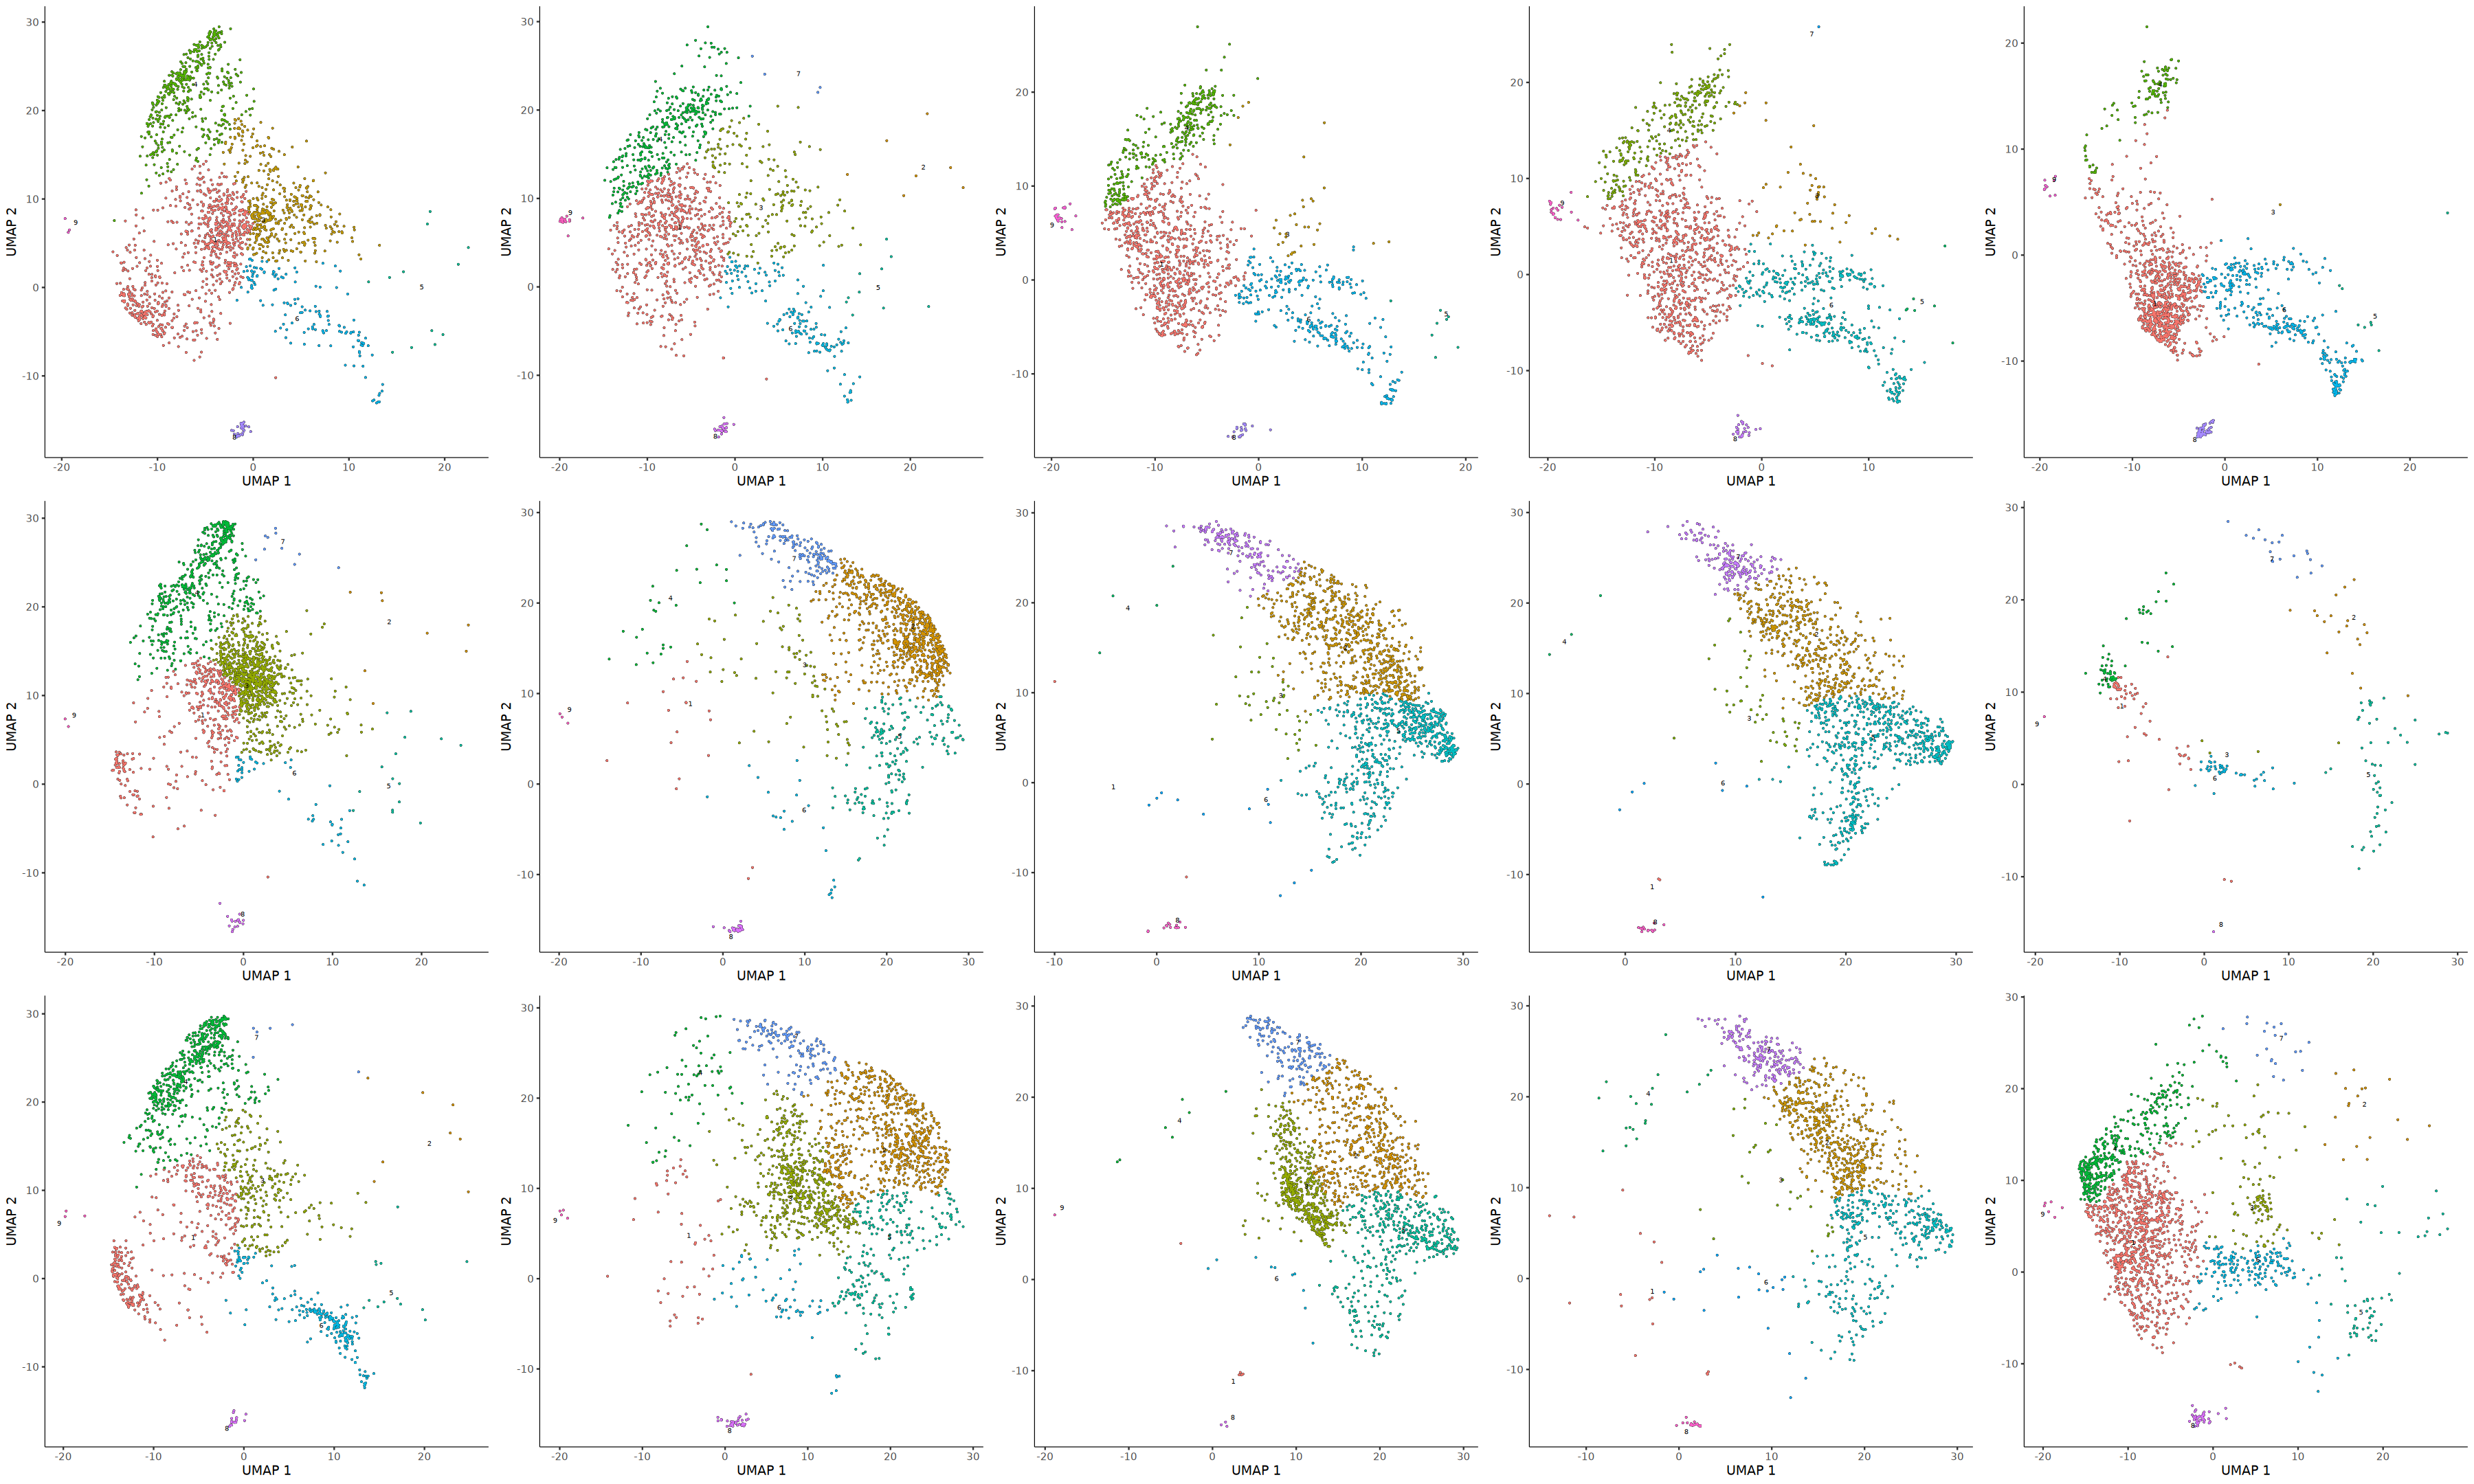

In [ ]:
library(magrittr)
# one plot for each sample
plot_list = list()
for (sampleid in sort(unique(cds$sample))) {
  plot_list[[sampleid]] = cds[
    , colData(cds) %>% subset(sample == sampleid) %>% row.names
    ] %>%
    plot_cells(show_trajectory_graph = F)
}

# plot all plots in 5 columns
options(repr.plot.width = 30, repr.plot.height = 18)
suppressWarnings(do.call(gridExtra::grid.arrange, c(plot_list, ncol = 5)))

Cells aren't colored in a way that allows them to be grouped.



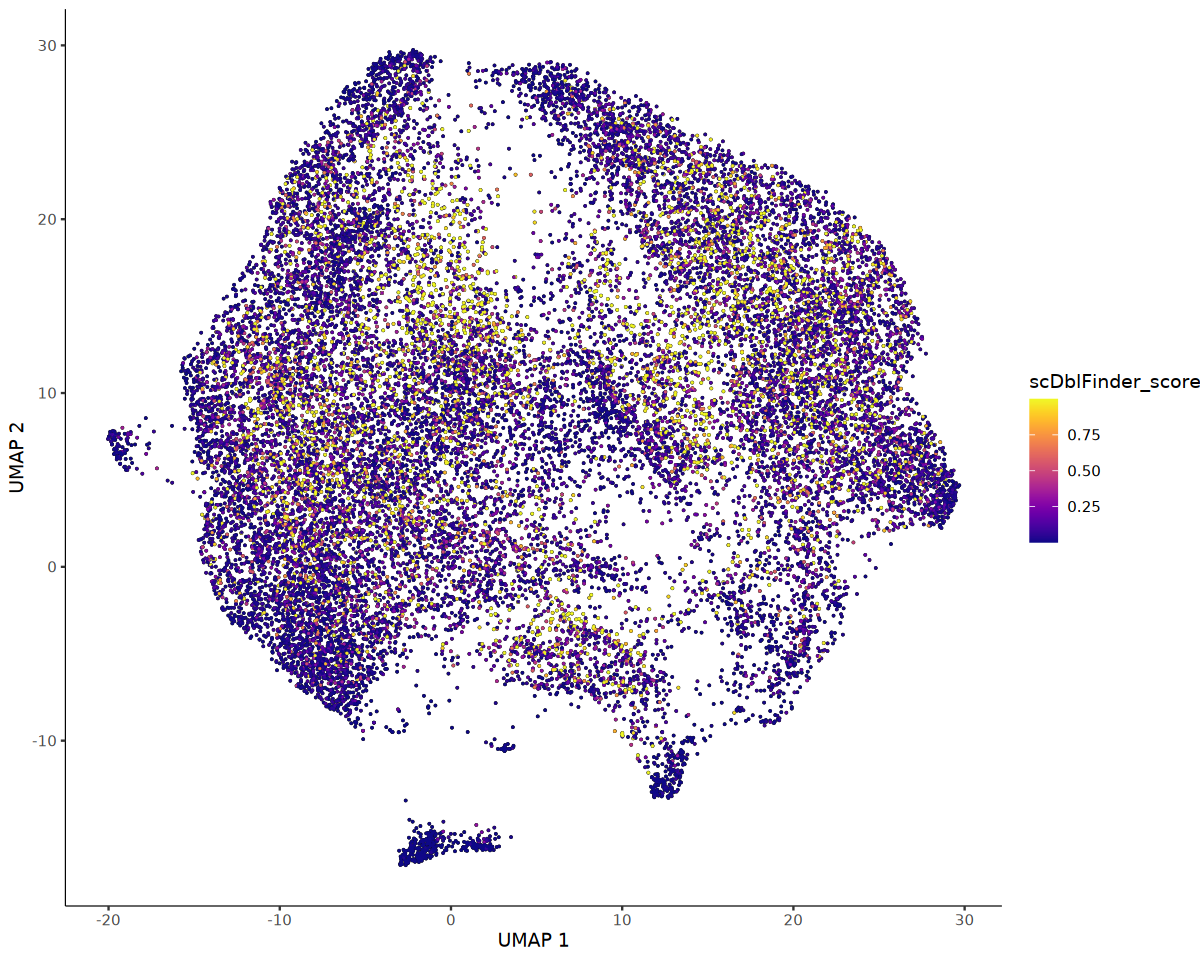

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)
plot_cells(cds, show_trajectory_graph = F, color_cells_by = "scDblFinder_score")

In [ ]:
## Step 5: Learn a graph
cds <- learn_graph(cds)

  |======================================================================| 100%
  |======================================================================| 100%


In [ ]:
get_earliest_principal_node <- function(cds, time_bin="1"){
  cell_ids <- which(colData(cds)[, "week"] == time_bin)

  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
    igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
   (which.max(table(closest_vertex[cell_ids,]))))]

  root_pr_nodes
}
## Step 6: Order cells
cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

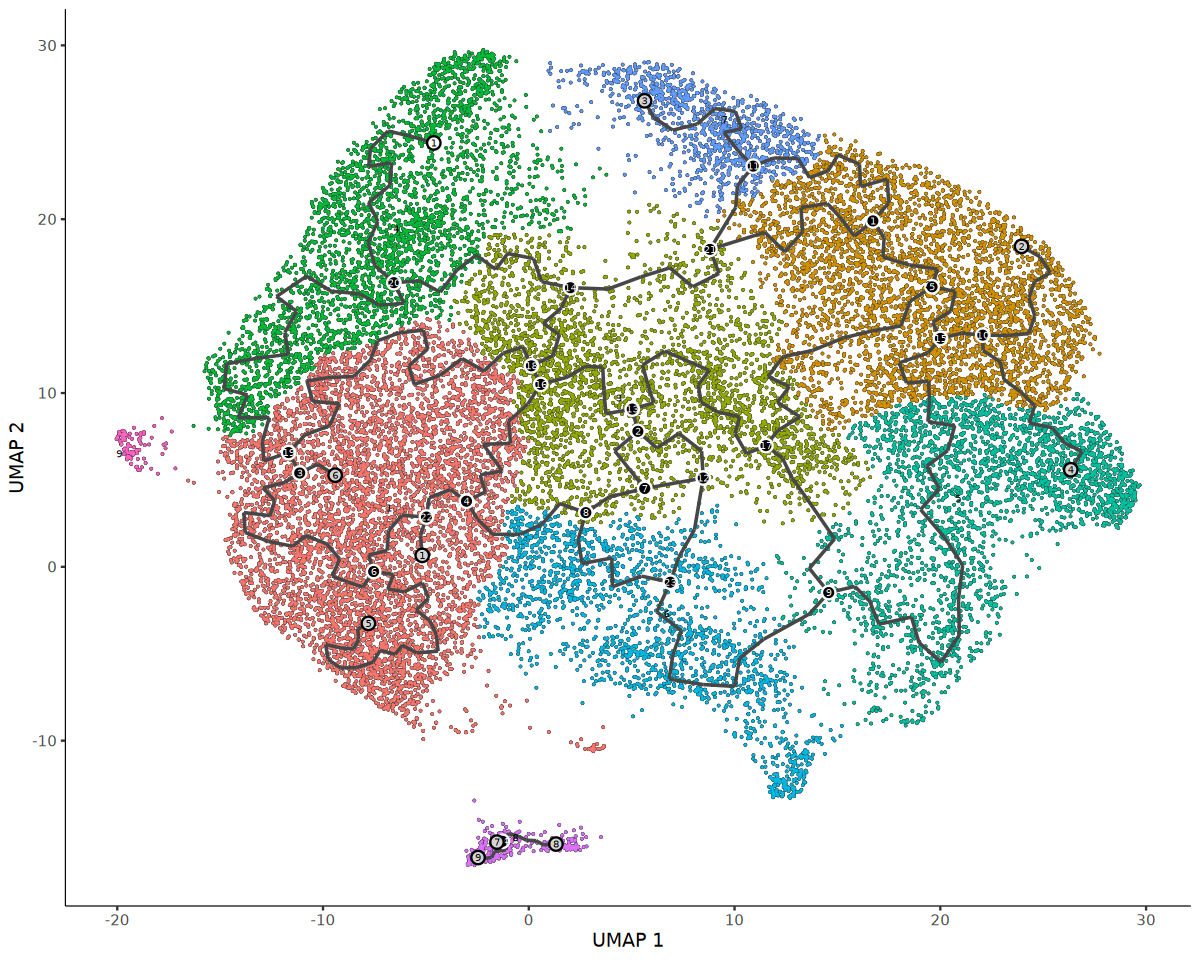

In [ ]:
plot_cells(cds)

Cells aren't colored in a way that allows them to be grouped.



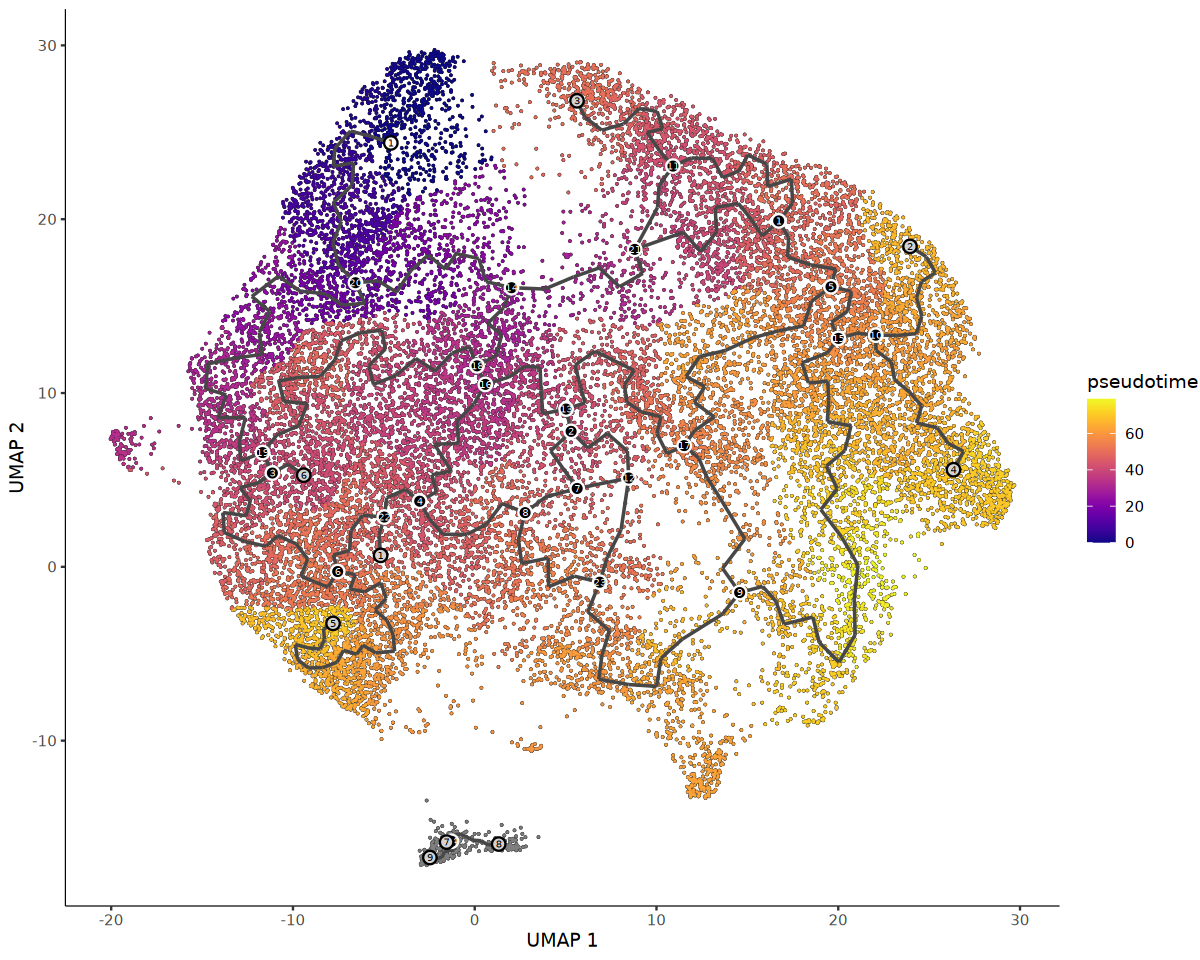

In [ ]:
plot_cells(cds, color_cells_by = "pseudotime")

# Trajectories for every treatment

Learn new graphs for every arm separately

[1] "The order will be:"
[1] "Control" "Conti"   "OnOff"  


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


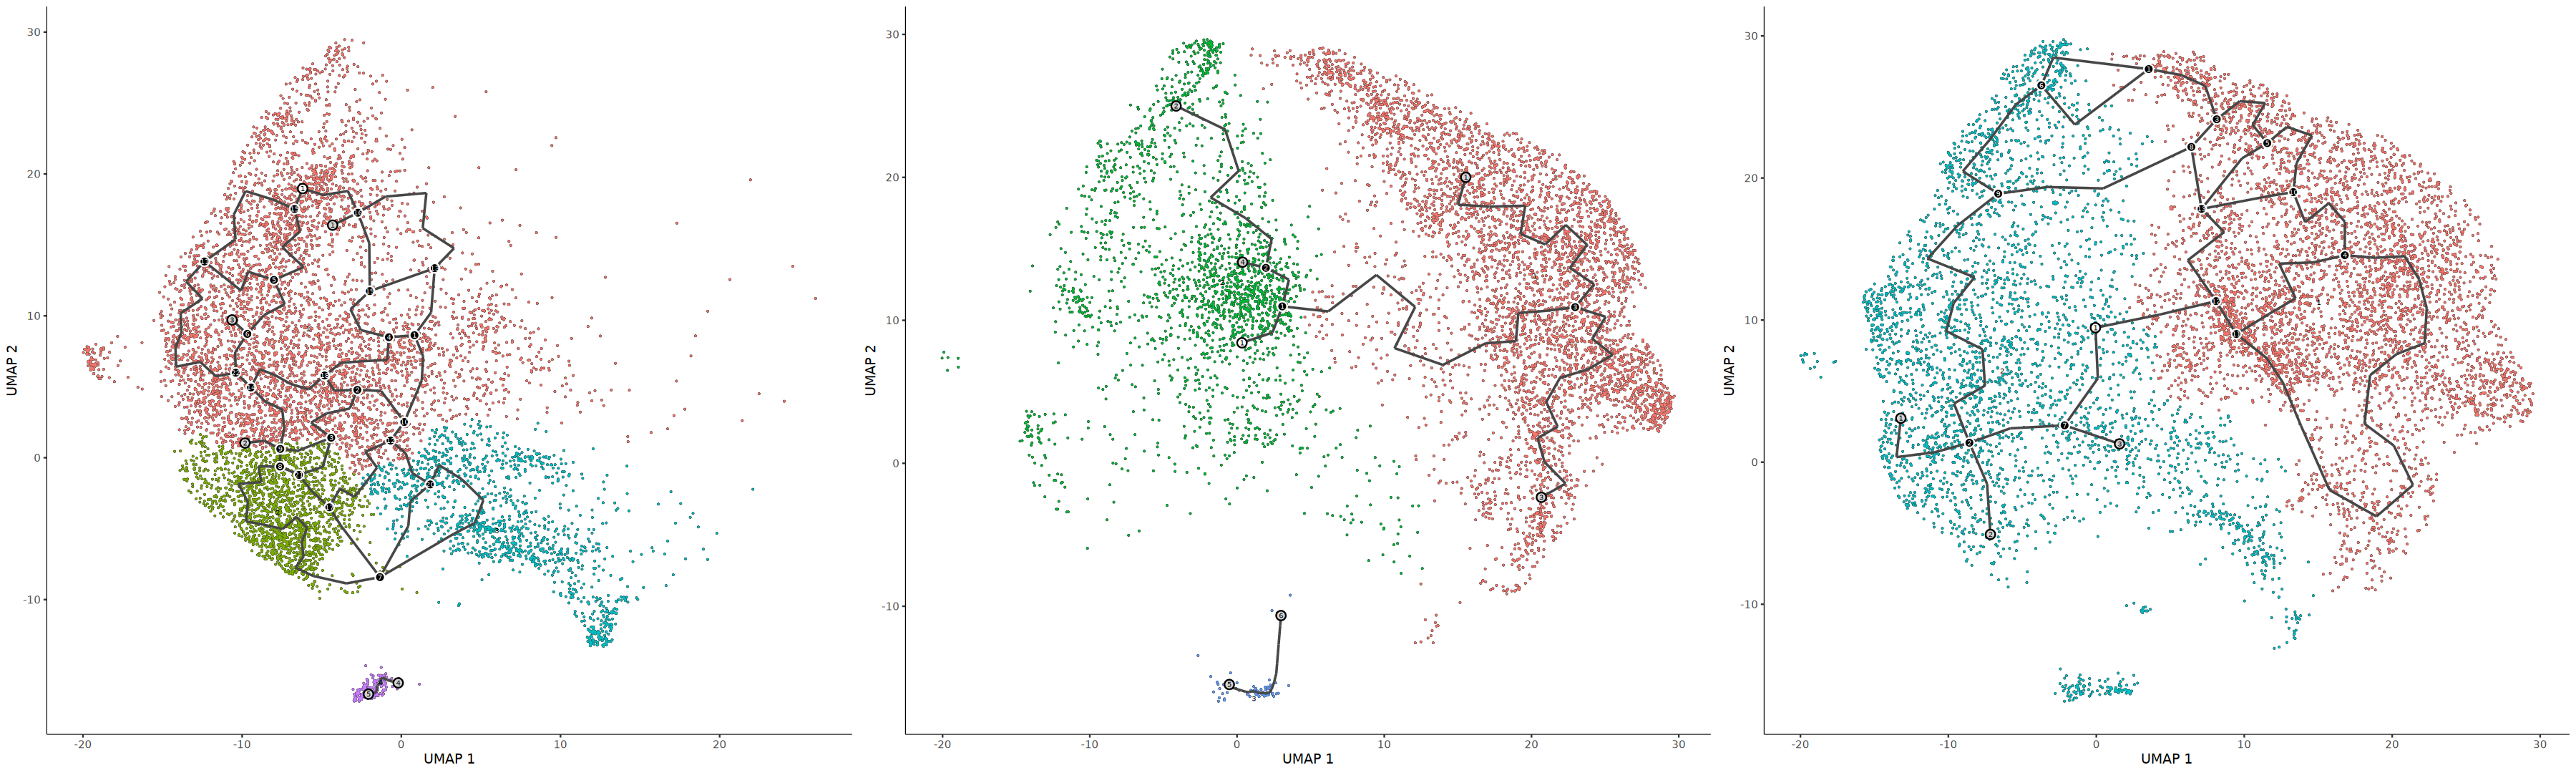

In [ ]:
tts = unique(cds$treatment)
print("The order will be:")
print(tts)

plot_list_tr = list()
for (t in tts) {
    cds_subset = cds[, colData(cds) %>% subset(treatment == t) %>% row.names]
    cds_subset = cluster_cells(cds_subset, verbose = F, cluster_method = "leiden")
    cds_subset <- learn_graph(cds_subset)
    cds_subset <- order_cells(cds_subset, root_pr_nodes=get_earliest_principal_node(cds_subset))
    plot_list_tr[[t]] = plot_cells(cds_subset)
}

# plot all plots in 3 columns
options(repr.plot.width = 30, repr.plot.height = 9)
suppressWarnings(do.call(gridExtra::grid.arrange, c(plot_list_tr, ncol = 3)))